In [1]:
import os
import json
import hypaad
import pickle

import pandas as pd
import seaborn as sns
import graphviz as gv
import matplotlib.pyplot as plt

from pathlib import Path

/Users/mats/git/master-thesis/hypaad/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
algorithms = {
    "Donut_final": "donut",
    "DWT-MLEAD_final": "dwt-mlead",
    "S2G_final": "series2graph",
    "Subsequence-IF_final": "sub_if",
    "Sub-LOF_final": "sub_lof",
    "STOMP_final": "stomp",
}
algorithm_order = list(algorithms.keys())

timeseries_names = [
    "sine-base",
    "ecg-base",
    "random-walk-base",
    "cylinder-bell-funnel-base",
]

base_dir = Path("../results")

In [3]:
color_map = {
    'default': '#407ba7',
    'timeeval': '#1b98e0',
    'optimization': '#82a0bc',
    'model': '#fb8500',
}
colors = list(color_map.values())
sns.color_palette(colors)

[(0.25098039215686274, 0.4823529411764706, 0.6549019607843137),
 (0.10588235294117647, 0.596078431372549, 0.8784313725490196),
 (0.5098039215686274, 0.6274509803921569, 0.7372549019607844),
 (0.984313725490196, 0.5215686274509804, 0.0)]

In [4]:
def get_study_name(algorithm: str, timeseries: str):
    return f"{algorithm}.{timeseries}"

def read_dict(path: Path):           
    with open(path) as file:
        return json.load(file)

## Figure 5

Empty graph received for study DWT-MLEAD_final.random-walk-base
Empty graph received for study DWT-MLEAD_final.cylinder-bell-funnel-base


<Figure size 6000x1200 with 0 Axes>

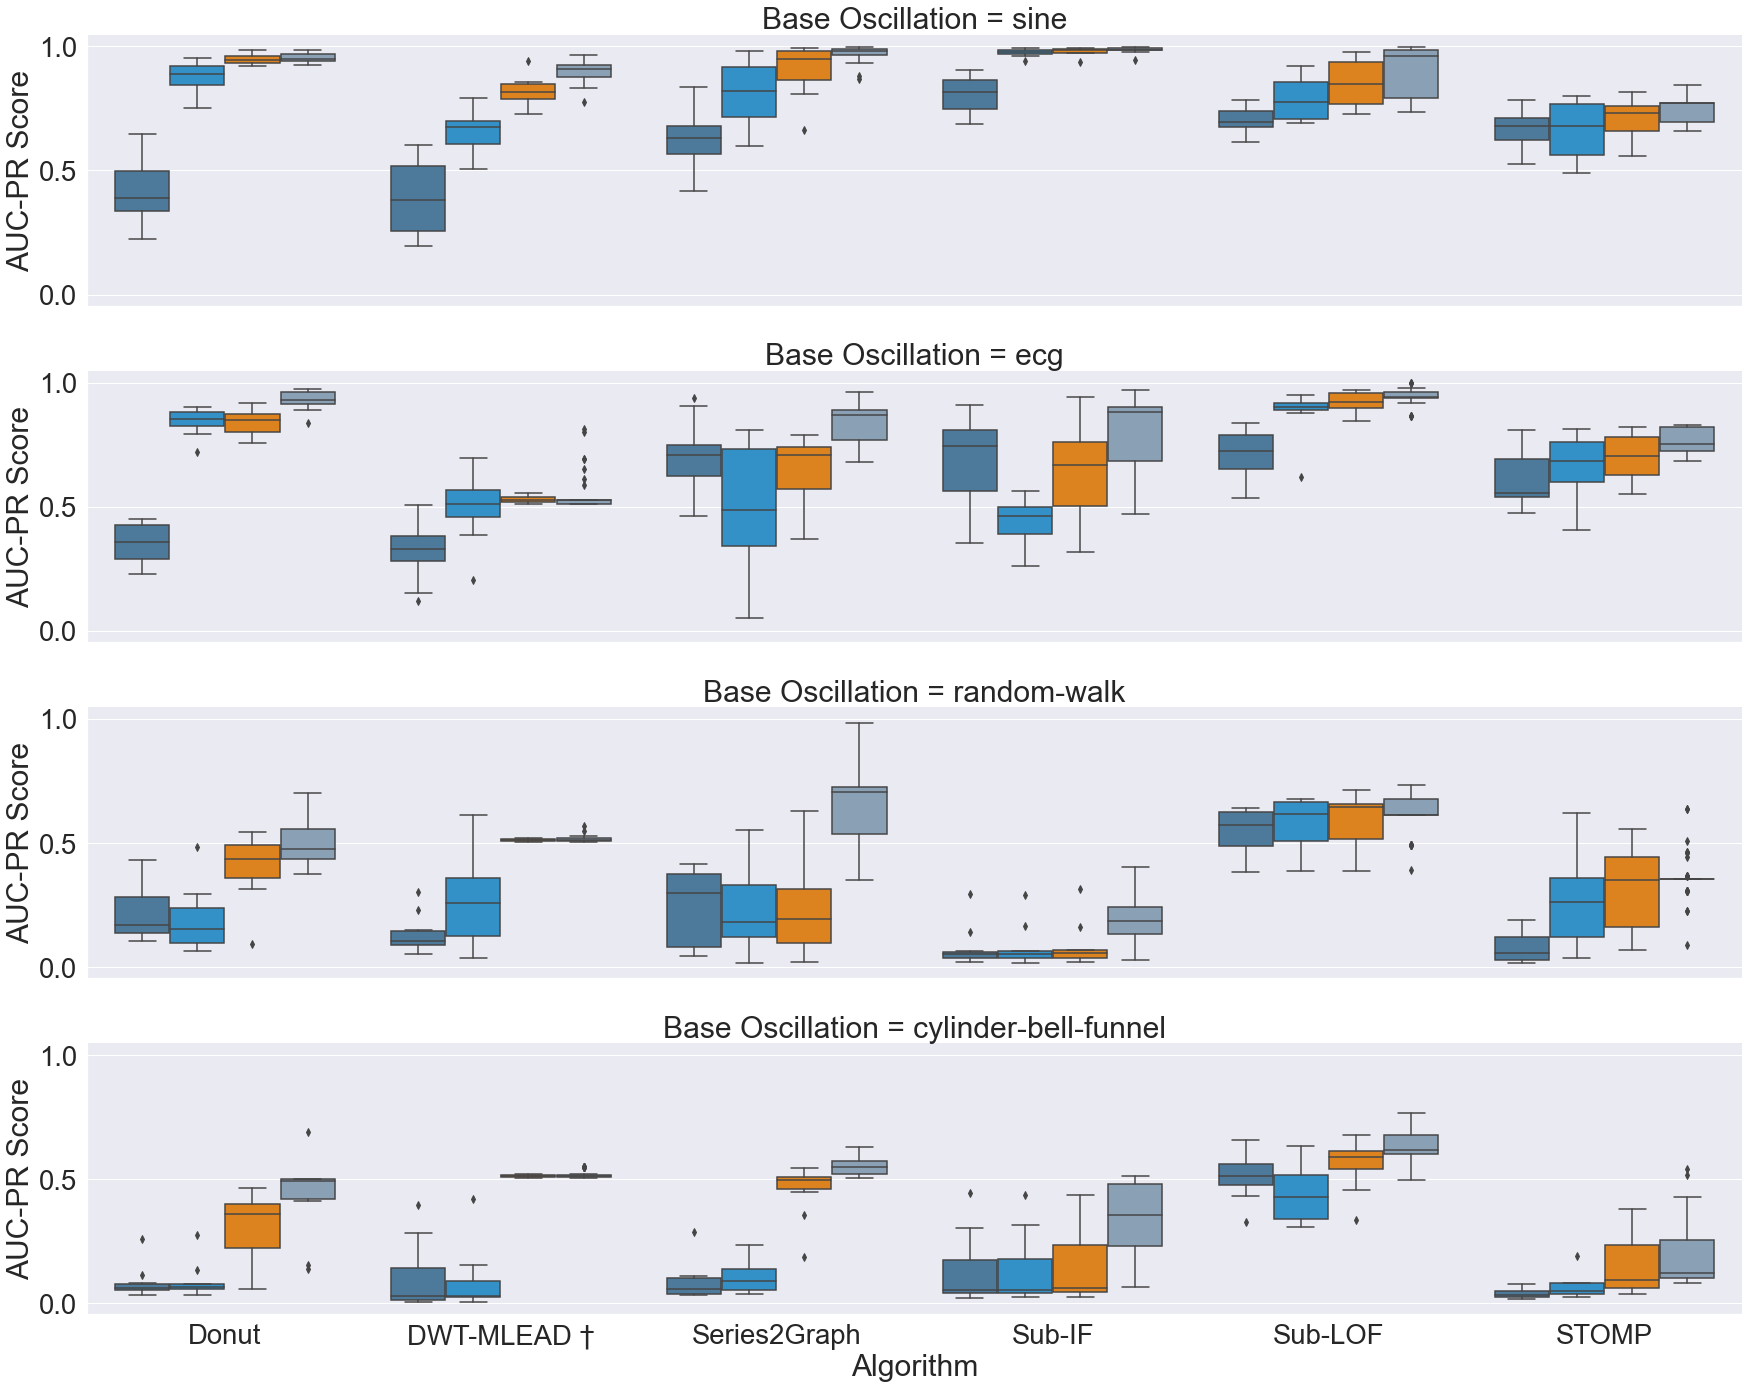

In [5]:
data = []
empty_graphs = []
variances = []


def _prepare_eval_dataset(path: Path, label: str):
    df_full = pd.read_csv(path)
    df_full["type"] = label
    max_scores = df_full.groupby(by='timeseries').agg({'auc_pr_score': 'max'}).reset_index(drop=False)
    
    dfs = []
    
    for idx, row in max_scores.iterrows():
        timeseries = row['timeseries']
        max_score = row['auc_pr_score']
        
        df = df_full[df_full.timeseries == timeseries].copy()
        df['is_max_score'] = df.auc_pr_score == max_score
        
        dfs.append(df)
        
    return pd.concat(dfs)


for algorithm in algorithms.keys():
    for timeseries_name in timeseries_names:
        study_name = get_study_name(algorithm, timeseries_name)
        evaluation_dir = base_dir / study_name / "evaluation"
        if not os.path.exists(evaluation_dir):
            continue
            
        validation_metadata = read_dict(base_dir / study_name / "best_thresholds" / "metadata.json")
        best_alpha_threshold = validation_metadata["best_alpha_threshold"]
        best_beta_threshold = validation_metadata["best_beta_threshold"]
        
        try:
            model_path = base_dir / study_name / "train" / "parameter_models" / f"alpha={best_alpha_threshold}_beta={best_beta_threshold}.pickle"
            with open(model_path, "rb") as f:
                parameter_model = pickle.load(f)
        except FileNotFoundError:
            print(f"Empty graph received for study {study_name}")
            empty_graphs.append((algorithm, timeseries_name))
            
        if len(parameter_model.pruned_graph.edges()) == 0:
            print(f"Empty graph received for study {study_name}")
            empty_graphs.append((algorithm, timeseries_name))
            
        
        trials_full_optim = pd.read_csv(base_dir / study_name / "evaluation" / "trial_results_full_optimization.csv")
        variances.append({
            'algorithm': algorithm,
            'timeseries_name': timeseries_name,
            'type': 'full optimization',
            'variance': trials_full_optim.auc_pr_score.var()
        })

            
        df_default_parameters = _prepare_eval_dataset(
            path=evaluation_dir / "trial_results_default_parameters.csv",
            label="Default Parameters",
        )
        df_full_optimization = _prepare_eval_dataset(
            path=evaluation_dir / "trial_results_full_optimization.csv",
            label="Full Optimization",
        )
        # Select maximum scores per time series only for the full optimization run
        df_full_optimization = df_full_optimization[df_full_optimization.is_max_score == True]
        
        df_timeeval_parameters = _prepare_eval_dataset(
            path=evaluation_dir / "trial_results_timeeval_parameters.csv",
            label="Timeeval Heuristics",
        )
        
        try:
            df_our_model = _prepare_eval_dataset(
                path=evaluation_dir / "trial_results_parameter_model.csv",
                label="Our Model",
            )
        except Exception:
            df_our_model = pd.DataFrame(columns=df_timeeval_parameters.columns)

        df = pd.concat([
            df_default_parameters,
            df_timeeval_parameters,
            df_our_model,
            df_full_optimization,
        ])
        df["base_oscillation"] = timeseries_name
        df["algorithm"] = algorithm
        data.append(df)

data = pd.concat(data)

# Set style
plt.figure(figsize=(20, 4), dpi=300)
plt.rcParams.update({
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'legend.fontsize': 22,
    'legend.title_fontsize': 22,
})
_palette = sns.color_palette([
    color_map['default'], 
    color_map['timeeval'], 
    color_map['model'], 
    color_map['optimization'], 
])
sns.set(font_scale=2.5)


# Rename algorihtms
algorithm_rename = [{
    algorithm: algorithm[:-6]
    for algorithm in algorithms.keys()
    if algorithm.endswith('_final')
}, {
    "DWT-MLEAD": "DWT-MLEAD †",
    "S2G": "Series2Graph",
    "Subsequence-IF": "Sub-IF",
}]
for alg_rename in algorithm_rename:
    for name, new_name in alg_rename.items():
        data.loc[data["algorithm"] == name, "algorithm"] = new_name
    
    
# Rename base oscillation behaviors
oscillation_rename = {
    "sine-base": "sine",
    "ecg-base": "ecg",
    "random-walk-base": "random-walk",
    "cylinder-bell-funnel-base": "cylinder-bell-funnel",
}
for name, new_name in oscillation_rename.items():
    data.loc[data["base_oscillation"] == name, "base_oscillation"] = new_name

    
# Rename columns uses as axes
data.rename(columns={
    "algorithm": "Algorithm",
    "base_oscillation": "Base Oscillation",
    "auc_pr_score": "AUC-PR Score"
}, inplace=True)


oscillation_order = [oscillation_rename.get(v, v) for v in timeseries_names]
algorithm_renamed_order = []
for alg in algorithm_order:
    final_name = alg
    for rename_rules in algorithm_rename:
        final_name = rename_rules.get(final_name, final_name)
    algorithm_renamed_order.append(final_name)

sns.catplot(
    data=data, kind="box", col="Base Oscillation", 
    col_order=oscillation_order, 
    order=algorithm_renamed_order,
    x="Algorithm", y="AUC-PR Score", hue="type",
    col_wrap=1, aspect=5, palette=_palette, legend=False,
)
plt.savefig("evaluation_absolute_performance.pdf")

# Figure 4

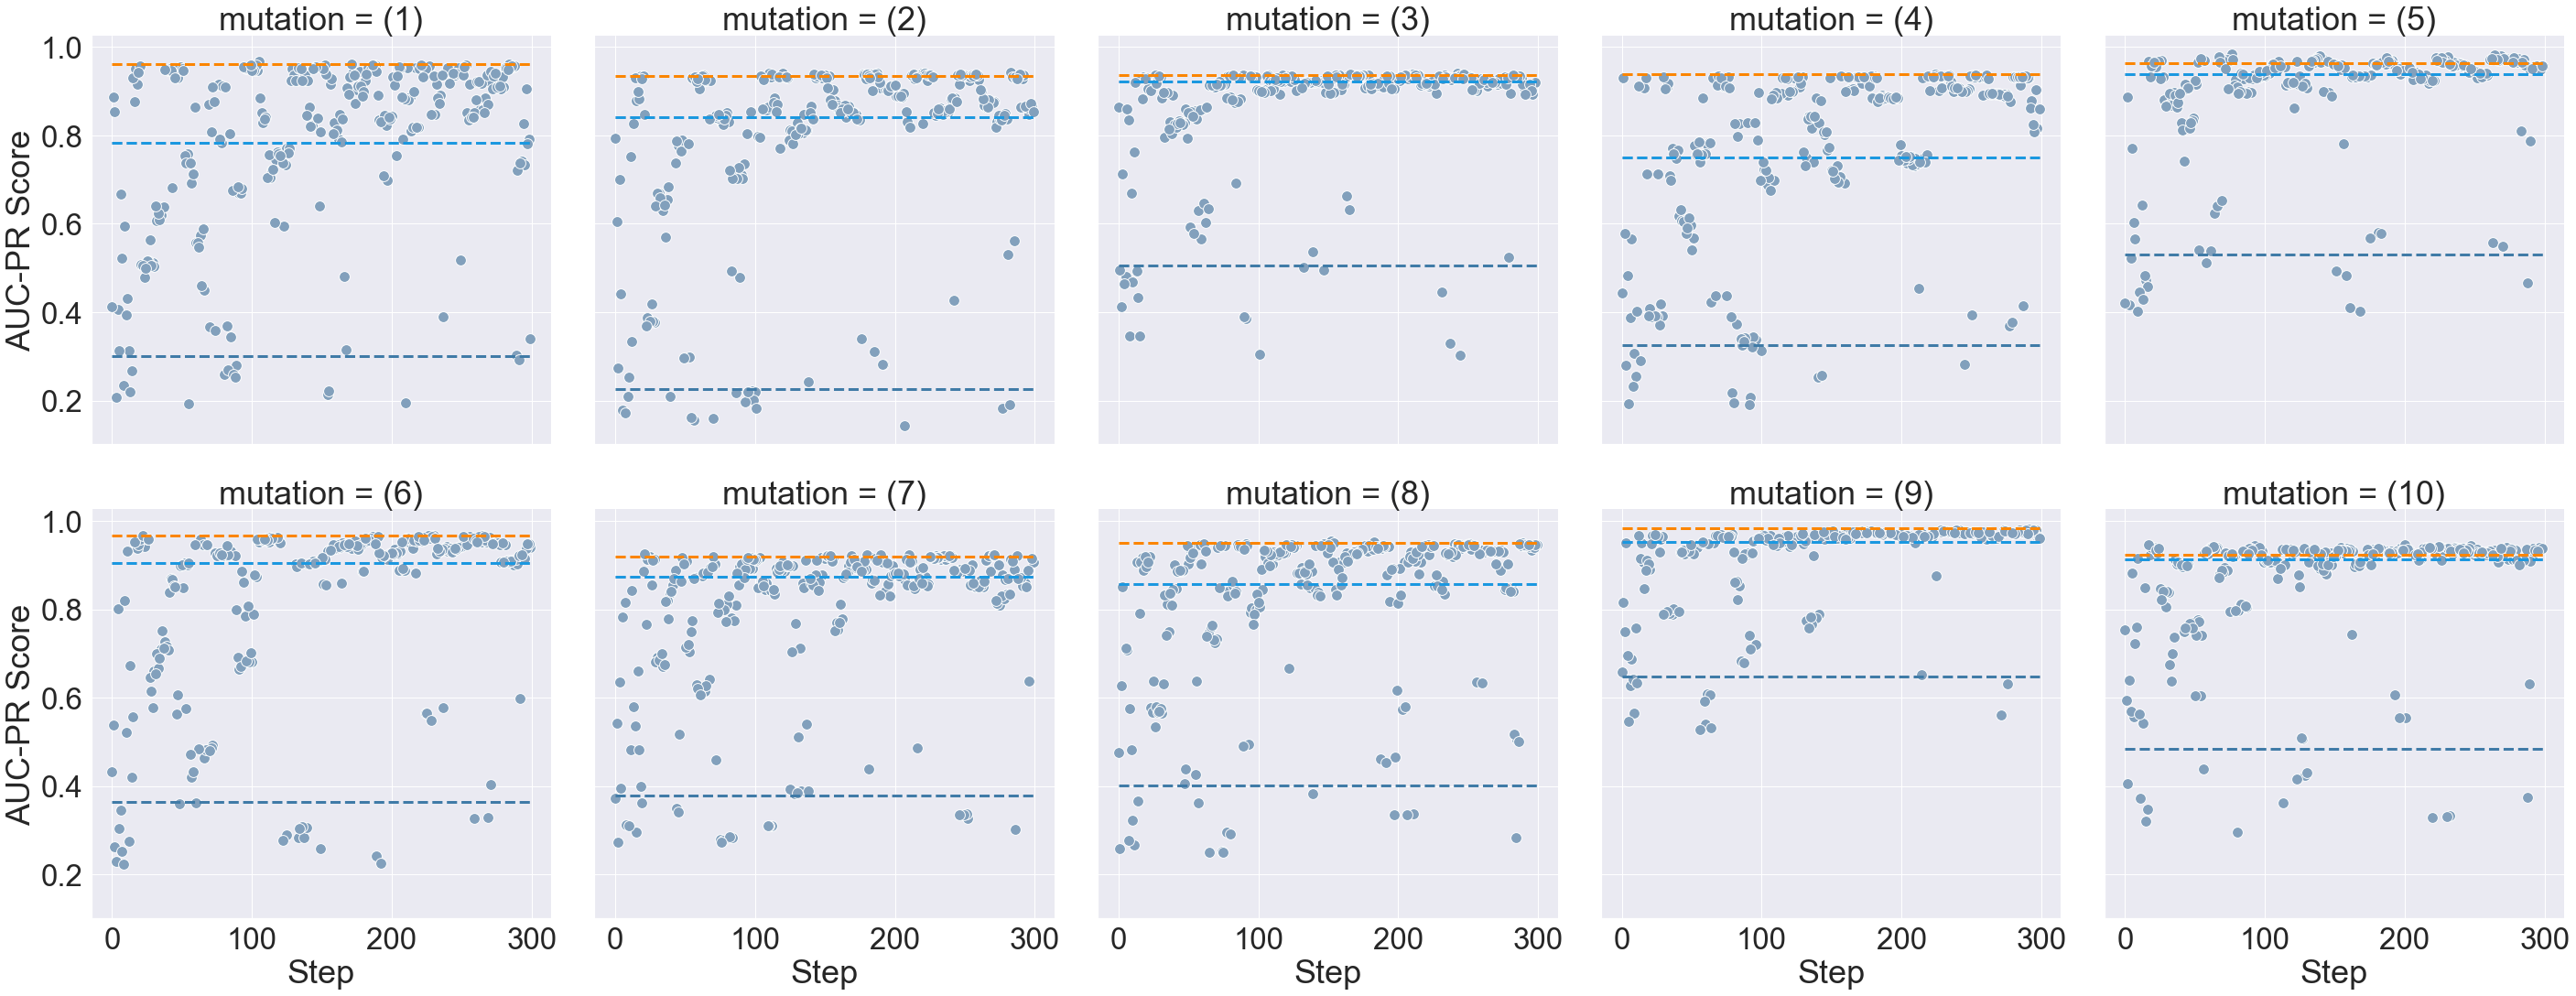

In [6]:
algorithm = 'Donut_final'
timeseries = 'sine-base'

study_name = get_study_name(algorithm, timeseries)


trials_default = pd.read_csv(base_dir / study_name / "evaluation" / "trial_results_default_parameters.csv")
trials_default['type'] = 'Default Parameters'
trials_timeeval = pd.read_csv(base_dir / study_name / "evaluation" / "trial_results_timeeval_parameters.csv")
trials_timeeval['type'] = 'Timeeval Heuristics'
trials_model = pd.read_csv(base_dir / study_name / "evaluation" / "trial_results_parameter_model.csv")
trials_model['type'] = 'Our Model'
trials_full_optim = pd.read_csv(base_dir / study_name / "evaluation" / "trial_results_full_optimization.csv")
trials_full_optim['type'] = 'Full Optimization'

df = pd.concat([
    trials_model,
    trials_full_optim,
    trials_default,
    trials_timeeval,
])

timeseries = {
    name: f"({idx+1})"
    for idx, name in enumerate(df['timeseries'].unique())
}

df['mutation'] = df['timeseries'].apply(lambda x: timeseries[x])

df.rename(columns={
    "id": "Step",
    "auc_pr_score": "AUC-PR Score",
}, inplace=True)

sns.set(font_scale=3)
g = sns.FacetGrid(df, col="mutation", hue='type', col_wrap=5, height=8, aspect=1)

def plot_scatter(*args, **kwargs):
    data = kwargs['data']
    color = kwargs['color']
    y = kwargs['y']

    if kwargs['label'] == 'Default Parameters':
        value = data[y].iloc[0]
        sns.lineplot(x=[0, df['Step'].max()], y=[value, value], color=color_map['default'], lw=3, linestyle='--')
        return

    if kwargs['label'] == 'Timeeval Heuristics':
        for value in data[y]:
            sns.lineplot(x=[0, df['Step'].max()], y=[value, value], color=color, lw=3, linestyle='--', alpha=0.4)

        max_value = data[y].max()
        sns.lineplot(x=[0, df['Step'].max()], y=[max_value, max_value], color=color_map['timeeval'], lw=3, linestyle='--')
        return

    if kwargs['label'] == 'Our Model':
        value = data[y].iloc[0]
        sns.lineplot(x=[0, df['Step'].max()], y=[value, value], color=color_map['model'], lw=3, linestyle='--')
        return

    _kwargs = {
        **kwargs,
        "color": color_map['optimization'] if kwargs['label'] == 'Full Optimization' else color_map['model'],
    }

    sns.scatterplot(*args, **_kwargs)

g.map_dataframe(plot_scatter, x="Step", y='AUC-PR Score', s=140)
plt.savefig("evaluation_donut_sine.pdf")

## Table 2

Algorithm: Donut_final
Timeseries: sine-base
Parameter Importances:
    window_size: 0.9892444260819945
    linear_hidden_size: 0.009403746112091573
    latent_size: 0.0006201712935875849
    epochs: 0.0003738791257359914
    regularization: 0.0001834159204810201
    random_state: 0.00017436146610940958


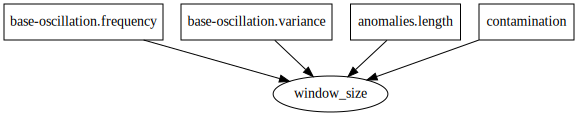

Timeseries: ecg-base
Parameter Importances:
    window_size: 0.9970163320930201
    random_state: 0.0008565007292455441
    linear_hidden_size: 0.0006686959019296325
    regularization: 0.0005784940779953134
    epochs: 0.0005294727879530255
    latent_size: 0.0003505044098564078


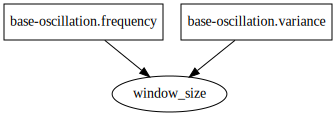

Timeseries: random-walk-base
Parameter Importances:
    window_size: 0.992132279027726
    regularization: 0.004739953825129565
    latent_size: 0.0011349837644769602
    linear_hidden_size: 0.0007563729110113836
    epochs: 0.0007405908503654702
    random_state: 0.000495819621290582


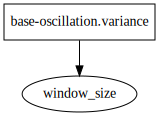

Timeseries: cylinder-bell-funnel-base
Parameter Importances:
    window_size: 0.9664913994430326
    epochs: 0.017514923092484074
    random_state: 0.0063752991708181895
    latent_size: 0.005691656357813526
    linear_hidden_size: 0.002057440451333878
    regularization: 0.0018692814845177278


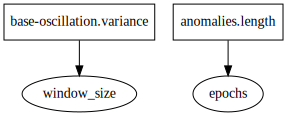

----------------------------------------------------------------------------------------------------
Algorithm: DWT-MLEAD_final
Timeseries: sine-base
Parameter Importances:
    start_level: 0.9554940918211613
    quantile_epsilon: 0.03492089945295856
    random_state: 0.009585008725880088


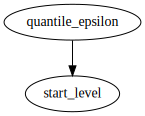

Timeseries: ecg-base
Parameter Importances:
    start_level: 0.9559718424105587
    quantile_epsilon: 0.03774410238596188
    random_state: 0.006284055203479377


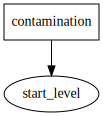

Timeseries: random-walk-base
Parameter Importances:
    start_level: 0.9997006870188541
    quantile_epsilon: 0.00021883578036786954
    random_state: 8.047720077800633e-05
Timeseries: cylinder-bell-funnel-base
Parameter Importances:
    start_level: 0.9994843757598765
    quantile_epsilon: 0.000323357707484206
    random_state: 0.00019226653263931096
----------------------------------------------------------------------------------------------------
Algorithm: S2G_final
Timeseries: sine-base
Parameter Importances:
    window_size: 0.6480219488927899
    query_window_size: 0.29413753363166056
    random_state: 0.04308294243801043
    rate: 0.01475757503753915


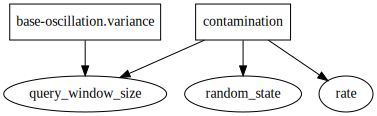

Timeseries: ecg-base
Parameter Importances:
    query_window_size: 0.42332502567617364
    window_size: 0.4124483132079767
    rate: 0.1440337092786612
    random_state: 0.020192951837188507


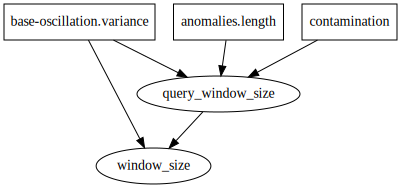

Timeseries: random-walk-base
Parameter Importances:
    window_size: 0.8396604589728152
    query_window_size: 0.09250384920960507
    rate: 0.05802203133316046
    random_state: 0.009813660484419366


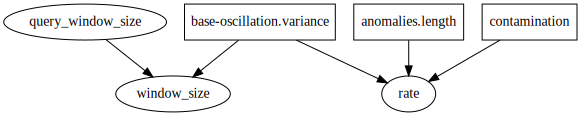

Timeseries: cylinder-bell-funnel-base
Parameter Importances:
    window_size: 0.9802188638599415
    rate: 0.018117605874725457
    random_state: 0.0008414579490330883
    query_window_size: 0.000822072316299964


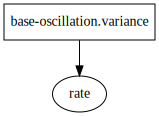

----------------------------------------------------------------------------------------------------
Algorithm: Subsequence-IF_final
Timeseries: sine-base
Parameter Importances:
    window_size: 0.9877753201380077
    random_state: 0.01083454983740544
    n_trees: 0.0013901300245867676


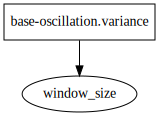

Timeseries: ecg-base
Parameter Importances:
    window_size: 0.6233047375833707
    n_trees: 0.22491043744453637
    random_state: 0.15178482497209292


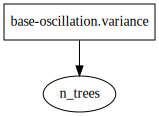

Timeseries: random-walk-base
Parameter Importances:
    window_size: 0.8678430391697632
    random_state: 0.07639201960872057
    n_trees: 0.05576494122151625


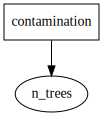

Timeseries: cylinder-bell-funnel-base
Parameter Importances:
    window_size: 0.9482749144568879
    random_state: 0.032648945129131836
    n_trees: 0.019076140413980286


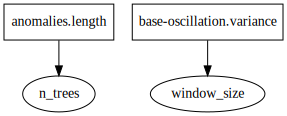

----------------------------------------------------------------------------------------------------
Algorithm: Sub-LOF_final
Timeseries: sine-base
Parameter Importances:
    window_size: 0.9862534848403187
    n_neighbors: 0.010329156487642452
    random_state: 0.0019605531723952316
    leaf_size: 0.0014568054996436594


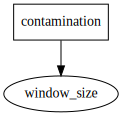

Timeseries: ecg-base
Parameter Importances:
    window_size: 0.981904221095154
    n_neighbors: 0.01622150187246408
    random_state: 0.001249742435570484
    leaf_size: 0.0006245345968114235


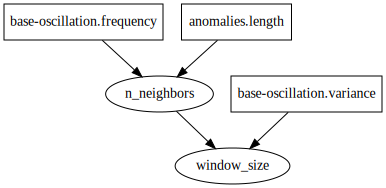

Timeseries: random-walk-base
Parameter Importances:
    window_size: 0.9919551013436303
    leaf_size: 0.002830842882007916
    random_state: 0.0026891024827788807
    n_neighbors: 0.0025249532915828615


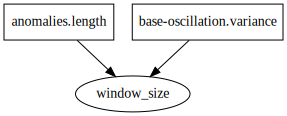

Timeseries: cylinder-bell-funnel-base
Parameter Importances:
    window_size: 0.9932322341333365
    random_state: 0.004378802661411912
    leaf_size: 0.0013744313178148063
    n_neighbors: 0.001014531887436841


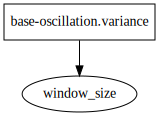

----------------------------------------------------------------------------------------------------
Algorithm: STOMP_final
Timeseries: sine-base
Parameter Importances:
    anomaly_window_size: 0.9995407293050507
    exclusion_zone: 0.00025866232573280997
    random_state: 0.00020060836921657765


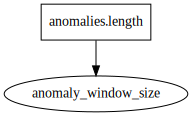

Timeseries: ecg-base
Parameter Importances:
    anomaly_window_size: 0.9994811908045261
    exclusion_zone: 0.00035438972261936114
    random_state: 0.00016441947285451207


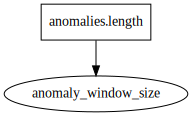

Timeseries: random-walk-base
Parameter Importances:
    anomaly_window_size: 0.9864780323399114
    random_state: 0.009882782782032702
    exclusion_zone: 0.0036391848780559827


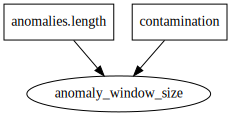

Timeseries: cylinder-bell-funnel-base
Parameter Importances:
    anomaly_window_size: 0.9986046171167293
    exclusion_zone: 0.0008147381787098751
    random_state: 0.0005806447045607621


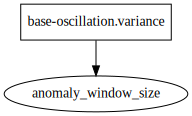

----------------------------------------------------------------------------------------------------


In [7]:
import networkx as nx
import typing as t
from pprint import pprint


def _plot_graph(algorithm: str, ts_name: str):
    nodes = set()
    mutation_nodes = set()
    edges = {}
    
    study_name = get_study_name(algorithm, ts_name)
    metadata = read_dict(base_dir / study_name / "best_thresholds" / "metadata.json")
    best_alpha_threshold = metadata["best_alpha_threshold"]
    best_beta_threshold = metadata["best_beta_threshold"]

    for n in [
        e['name']
        for e in list(read_dict(base_dir / study_name / "train" / "timeseries_mutations.json").values())[0]
    ]:
        mutation_nodes.add(n)

    if best_alpha_threshold is None:
        return

    model_path = base_dir / study_name / "train" / "parameter_models" / f"alpha={best_alpha_threshold}_beta={best_beta_threshold}.pickle"
    with open(model_path, "rb") as f:
        parameter_model = pickle.load(f)

    edges[ts_name] = parameter_model.pruned_graph.edges()
    for node_from, node_to in edges[ts_name]:
        nodes.add(node_from)
        nodes.add(node_to)
    
    g = gv.Digraph()
    for node in nodes:
        shape = 'box' if node in mutation_nodes else None
        g.node(node, shape=shape)
    
    for ts_name, edges in edges.items():
        for edge in edges:
            g.edge(*edge)
    
    display(g)
    
    
def plot_graphs(algorithm: str):
    for ts_name in timeseries_names:
        print("Timeseries:", ts_name)
        if algorithm.endswith('_final'):
            algorithm_no_suffix = algorithm[:-6]
        
        study_name_no_suffix = get_study_name(algorithm_no_suffix, ts_name)
        study_name = get_study_name(algorithm, ts_name)
        
        print("Parameter Importances:")
        parameter_importances = read_dict(base_dir / study_name / "train" / "parameter_importances.json")[study_name_no_suffix]
        for param, score in parameter_importances.items():
            print(f"    {param}: {score}")
        
        _plot_graph(
            algorithm=algorithm,
            ts_name=ts_name,
        )
    

for alg in algorithms.keys():
    print("Algorithm:", alg)
    plot_graphs(algorithm=alg)
    print("-" * 100)

## Figure 6

Best thresholds: alpha=0.24 beta=0.2


,,AUC-PR Score
"Thresholds (α, β)",graph_hash,
"(0.06, 0.2)",70b8896c6c27fce9c45c1273affc029f,0.666026
"(0.08, 0.2)",6900879628675d7bd0db971c02dc6b3b,0.666026
"(0.15, 0.2)",287c11138ca68d6961d4d3e5c5dc0231,0.666026
"(0.17, 0.2)",5e51d68c30015fab2677185ec0ed6627,0.664601
"(0.24, 0.2) †",d6d3ba76f466783d704f0e7e6d459a41,0.705492
"(0.46, 0.2)",a7bec70ca8b5e931b988bd90be29effa,0.676764


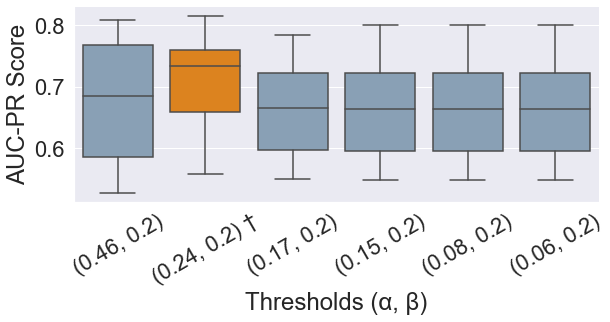

In [8]:
graph_hashes = {}

algorithm = "STOMP"
base_osci = "sine"

study_name = f"{algorithm}_final.{base_osci}-base"
train_metadata = read_dict(base_dir / study_name / "train" / "metadata.json")
best_thresholds = read_dict(base_dir / study_name / "best_thresholds" / "metadata.json")
best_alpha_threshold = best_thresholds['best_alpha_threshold']
best_beta_threshold = best_thresholds['best_beta_threshold']
print(f"Best thresholds: alpha={best_alpha_threshold} beta={best_beta_threshold}")

for item in train_metadata:
    alpha = item['alpha']
    beta = item['beta']
    model_path = base_dir / study_name / "train" / "parameter_models" / f"alpha={alpha}_beta={beta}.pickle"
    with open(model_path, "rb") as f:
        parameter_model = pickle.load(f)
    
    graph_hash = nx.weisfeiler_lehman_graph_hash(
        parameter_model.pruned_graph
    )
    graph_hashes[graph_hash] = graph_hashes.get(graph_hash, []) + [(alpha, beta)]

_best_params = {}
_d = {}
c = 0
for graph_hash, values in graph_hashes.items():
    c += 1
    _study_name = f"{algorithm}_{graph_hash}.{base_osci}-base"
    if (best_alpha_threshold, best_beta_threshold) in values:
        _study_name = study_name
        c -= 1
        
    try:
        _df = pd.read_csv(base_dir / _study_name / "evaluation" / "trial_results_parameter_model.csv")
        _d['AUC-PR Score'] = _d.get('AUC-PR Score', []) + list(_df.auc_pr_score)
        _d['graph_hash'] = _d.get('graph_hash', []) + [graph_hash] * len(_df)
        
        if _study_name == study_name:
            val = f'{values[0]} †'
        else:
            val = str(values[0])
        _d['Thresholds (α, β)'] = _d.get('Thresholds (α, β)', []) + [val] * len(_df)
        _d['study_name'] = _d.get('study_name', []) + [study_name] * len(_df)

    except FileNotFoundError:
        print(f"Did not find {_study_name}")


_df = pd.DataFrame(_d)
display(_df.groupby(['Thresholds (α, β)', 'graph_hash']).agg('mean'))

sns.set(font_scale=2)
_colors = [color_map['optimization'], color_map['model']] + [color_map['optimization']] * 4
ax = sns.catplot(
    data=_df, kind="box", x="Thresholds (α, β)", y="AUC-PR Score",
    aspect=1.8, palette=sns.color_palette(_colors),
)

for axes in ax.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)

plt.tight_layout()
plt.savefig("evaluation_stomp_sine_thresholds.pdf")